In [69]:
import pandas as pd 
data = pd.read_csv('CE802_Ass_2019_Data.csv').sample(frac=1, random_state=42)
test_features = pd.read_csv('CE802_Ass_2019_Test.csv').drop("Class", axis=1)

In [70]:
cor_mat = data.corr()
cor_mat["Class"].sort_values(ascending=False);

In [71]:
split = int(len(data) * 0.13)
validation = data[0:split]
train = data[split:]

In [72]:
train_labels = train["Class"]
train_features = train.drop("Class", axis=1)
validation_labels = validation["Class"]
validation_features = validation.drop("Class", axis=1)

In [73]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def featureSelection(X, level='low'):
    type(X)
    if level == 'low':
        return X
    if level == 'mid':
        return X.drop(['F18', 'F8', 'F11', 'F17'], axis=1)
    if level == 'high':
        return X.drop(['F3', 'F5', 'F18', 'F8', 'F11', 'F17', 'F6', 'F2'], axis=1)

def imputeF20(X, method='none'):
    if method == 'none':
        return pd.DataFrame(X)
    if method == 'drop':
        X = X.drop("F20",axis=1).values
        return pd.DataFrame(X)
    if method == 'constant':
        imp = SimpleImputer(strategy='constant')
    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
    if method == 'knn':
        imp = KNNImputer(n_neighbors=5)

    imp.fit(X)
    return pd.DataFrame(imp.transform(X))

def scale(X, method='none'):
    if method == 'none':
        return pd.DataFrame(X)
    if method == 'norm':
        scaler = MinMaxScaler()
    if method == 'std':
        scaler = StandardScaler()
    
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X))

In [74]:
selection_level = 'mid'
imputation_method = 'knn'
scaling_method = 'norm'

train_features_procesed = featureSelection(train_features, level=selection_level)
train_features_procesed = imputeF20(train_features_procesed, imputation_method)
train_features_procesed = scale(train_features_procesed, scaling_method )

validation_features_procesed = featureSelection(validation_features, selection_level)
validation_features_procesed = imputeF20(validation_features_procesed, imputation_method)
validation_features_procesed = scale(validation_features_procesed, scaling_method )

In [75]:
#### Prunned Decision tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [76]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(train_features_procesed, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [77]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(train_features_procesed, train_labels)
    clfs.append(clf)

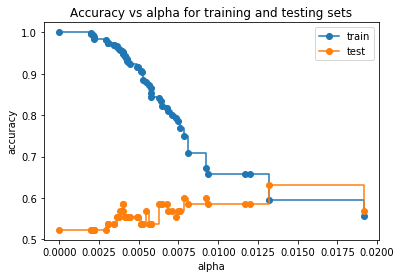

In [78]:
train_scores = [clf.score(train_features_procesed, train_labels) for clf in clfs]
test_scores = [clf.score(validation_features_procesed, validation_labels) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [79]:
def evaluateClassifier(clf):
    clf.fit(train_features_procesed, train_labels);
    results = clf.predict(validation_features_procesed)
    return f1_score(validation_labels, results)

In [80]:
from sklearn.metrics import f1_score

clf_decision_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
decision_tree_f1 = evaluateClassifier(clf_decision_tree)
print(decision_tree_f1)

0.49056603773584906


In [81]:
### Logistic Regression
from sklearn.linear_model import LogisticRegression

clf_logistic_reg = LogisticRegression(random_state=42)
logistic_reg_f1 = evaluateClassifier(clf_logistic_reg)
print(logistic_reg_f1)

0.4727272727272727


In [82]:
### Support vector machines
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
params = [
    {'kernel':['linear', 'rbf', 'sigmoid']},
    {'kernel': ['rbf'], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
]
clf = SVC()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)

clf_svc = SVC(kernel='rbf', gamma=1)
svm_f1 = evaluateClassifier(clf_svc)
print(svm_f1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.5185185185185186


In [83]:
### KNN
from sklearn.neighbors import KNeighborsClassifier
params = [
    {'n_neighbors':[3,4,5,7,9], 'weights': ['uniform', 'distance'], 'algorithm':['auto'], 'p':[1, 2]}
    ]
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)



clf_knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', n_neighbors=3, p=2, weights='uniform')
knn_f1 = evaluateClassifier(clf_knn)
print(knn_f1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
0.5161290322580646


In [84]:
### Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_naive_bayes = GaussianNB()
naive_bayes_f1 = evaluateClassifier(clf_naive_bayes)
print(naive_bayes_f1)

0.49180327868852464


In [85]:
### Perceptron
from sklearn.linear_model import Perceptron

params = [
        {'penalty':[None,'l1', 'l2', 'elasticnet']}
    ]
clf = Perceptron()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)

clf_perceptron = Perceptron(penalty='l2')
perceptron_f1 = evaluateClassifier(clf_perceptron)
print(perceptron_f1)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
0.5681818181818182


In [86]:
### MLP
from sklearn.neural_network import MLPClassifier

params = [{
            'hidden_layer_sizes':[(10, ),(30,),(50, ),(100, )],
            'activation':['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
            'alpha':[0.0001, 0.001, 0.01],
            'learning_rate': ['constant','invscaling','adaptive'],
            'random_state': [0],
            'early_stopping': [True],
            'max_iter': [300]
        }]
# clf = MLPClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

clf_mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
mlp_f1 = evaluateClassifier(clf_mlp)
print(mlp_f1)

0.6666666666666665
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [87]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
params = [{
    'n_estimators': [50,100,200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,7,9],
    'min_samples_split': [2,4,6,8],
    'min_samples_leaf': [1,2,3,4],
    'ccp_alpha': [0.001, 0.005, 0.01, 0.012]
}]
# clf = RandomForestClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

clf_random_forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.005, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
random_forest_f1 = evaluateClassifier(clf_random_forest)
print(random_forest_f1)

0.5384615384615384


In [88]:
from sklearn.ensemble import GradientBoostingClassifier

params = [{
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 125, 150],
    'min_samples_split': [2,3,5,6],
    'min_samples_leaf': [1, 2, 3, 4],
    'ccp_alpha': [0.001, 0.005, 0.01, 0.012]
}]

# clf = GradientBoostingClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True, n_jobs=5)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

clf_gradient_boosting = GradientBoostingClassifier(ccp_alpha=0.001, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
gradient_boosting_f1 = evaluateClassifier(clf_gradient_boosting)
print(gradient_boosting_f1)

0.5762711864406779


In [96]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('clf_decision_tree', clf_decision_tree),
    ('clf_logistic_reg', clf_logistic_reg),
    ('clf_svc', clf_svc),
    ('clf_naive_bayes', clf_naive_bayes),
    ('clf_perceptron', clf_perceptron),
    ('clf_mlp', clf_mlp),
    ('clf_random_forest', clf_random_forest),
    ('clf_gradient_boosting', clf_gradient_boosting),
]
clf_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_f1 = evaluateClassifier(clf_stacking)
print(stacking_f1)

/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [90]:
from sklearn.ensemble import VotingClassifier
clf_voting = VotingClassifier(estimators=estimators, voting='', n_jobs=8)
voting_f1 = evaluateClassifier(clf_stacking)
print(voting_f1)

/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [91]:
# low: 0.57 0.60
# mid: 0.62 0.64
# high: 0.47 0.44

In [106]:
train_labels.sum() / train_labels.shape[0]
validation_labels.sum() / validation_labels.shape[0]

0.4436781609195402

0.4307692307692308

0.4436781609195402